##**Personalized Healthcare Treatment Using Reinforcement Learning**

**Team members - Garima Badhan, Pragya Mittal**

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import gym
from gym import spaces
import tensorflow as tf
from tensorflow.keras import layers
from collections import deque


### Load the dataset and perform preprocessing

In [ ]:

# Load the dataset
file_path = '/content/healthcare_dataset.csv'  #dataset from kaggle
data = pd.read_csv(file_path)

if 'Name' in data.columns:
    data['Name'] = data['Name'].str.upper()

# Display basic information about the dataset
print("Dataset Overview:")
print(data.info())

print("\nFirst Five Rows of the Dataset:")
print(data.head())

# Check for missing values
missing_values = data.isnull().sum()
print("\nMissing Values in Each Column:")
print(missing_values)

# Basic statistics of numeric columns
print("\nDescriptive Statistics:")
print(data.describe())

# Convert potential numeric columns with mixed types to numeric, coercing errors to NaN
for col in data.columns:
    try:
        data[col] = pd.to_numeric(data[col], errors='coerce')
    except Exception as e:
        print(f"Could not convert column {col}: {e}")

# Drop rows with NaNs in critical columns
data = data.dropna()

# Check data types after conversion
print("\nData Types After Conversion:")
print(data.dtypes)





Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55500 entries, 0 to 55499
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                55500 non-null  object 
 1   Age                 55500 non-null  int64  
 2   Gender              55500 non-null  object 
 3   Blood Type          55500 non-null  object 
 4   Medical Condition   55500 non-null  object 
 5   Date of Admission   55500 non-null  object 
 6   Doctor              55500 non-null  object 
 7   Hospital            55500 non-null  object 
 8   Insurance Provider  55500 non-null  object 
 9   Billing Amount      55500 non-null  float64
 10  Room Number         55500 non-null  int64  
 11  Admission Type      55500 non-null  object 
 12  Discharge Date      55500 non-null  object 
 13  Medication          55500 non-null  object 
 14  Test Results        55500 non-null  object 
dtypes: float64(1), int64(2), object(12)

Define Environment and perform DQN model

In [ ]:

# Step 1: Define the Healthcare Environment
class HealthcareEnv(gym.Env):
    def __init__(self):
        super(HealthcareEnv, self).__init__()
        self.action_space = spaces.Discrete(3)  # 3 possible treatments
        self.observation_space = spaces.Box(low=0, high=1, shape=(10,), dtype=np.float32)  # 10 health features
        self.state = np.zeros(10)  # Initialize state with zeros
        self.steps = 0
        self.max_steps = 100  # Episode ends after 100 steps

    def reset(self):
        self.state = np.random.rand(10)  # Reset state to a random vector (10 features)
        self.steps = 0
        return self.state

    def step(self, action):

        health_score = -np.sum(self.state)  # Simulated health score (negative values penalize poor states)
        reward = health_score + action * np.random.normal(0, 1)  # Reward influenced by action
        self.state = np.random.rand(10)  # Simulated state transition
        self.steps += 1
        done = self.steps >= self.max_steps  # Terminate after max steps
        return self.state, reward, done, {}

    def render(self):
        print(f"Current state: {self.state}")

# Step 2: Build the Deep Q-Network Model
def build_model(state_size, action_size):
    inputs = tf.keras.Input(shape=(state_size,))
    x = layers.Dense(64, activation='relu')(inputs)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(action_size, activation='linear')(x)  # Output Q-values for each action
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
    return model

# Step 3: Define the DQN Agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)  # Experience replay memory
        self.gamma = 0.95  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01  # Minimum epsilon value
        self.epsilon_decay = 0.995  # Epsilon decay factor
        self.model = build_model(state_size, action_size)  # DQN model
        self.target_model = build_model(state_size, action_size)  # Target model
        self.update_target_model()

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.choice(range(self.action_size))  # Exploration: Random action
        q_values = self.model.predict(state, verbose=0)  # Exploitation: Choose the best action
        return np.argmax(q_values[0])

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.max(self.target_model.predict(next_state, verbose=0)[0])
            target_f = self.model.predict(state, verbose=0)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay



### Defining baselines - random policy and heuristic policy

In [ ]:
def random_policy(env, episodes=100):
    total_rewards = []
    for _ in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        while not done:
            action = env.action_space.sample()  # Random action
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
        total_rewards.append(total_reward)
    avg_reward = np.mean(total_rewards)
    print(f"Random Policy Average Reward: {avg_reward:.2f}")
    return avg_reward


In [ ]:
def heuristic_policy(env, episodes=100):
    total_rewards = []
    for _ in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        while not done:
            action = np.argmin(state) % env.action_space.n  # Choose based on a heuristic
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
        total_rewards.append(total_reward)
    avg_reward = np.mean(total_rewards)
    print(f"Heuristic Policy Average Reward: {avg_reward:.2f}")
    return avg_reward


### Comparison of baseline and the dqn model

In [ ]:
if __name__ == "__main__":
    env = HealthcareEnv()
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    agent = DQNAgent(state_size, action_size)

    # Baselines
    random_avg = random_policy(env)
    heuristic_avg = heuristic_policy(env)

    # Train DQN Agent
    episodes = 100
    batch_size = 32
    dqn_rewards = []

    for e in range(episodes):
        state = env.reset()
        state = np.reshape(state, [1, state_size])
        total_reward = 0
        for time in range(500):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            if done:
                print(f"Episode {e+1}/{episodes}, Total Reward: {total_reward:.2f}, Epsilon: {agent.epsilon:.2f}")
                break
        dqn_rewards.append(total_reward)
        agent.replay(batch_size)
        agent.update_target_model()

    # Compare Results
    dqn_avg = np.mean(dqn_rewards)
    print(f"DQN Agent Average Reward: {dqn_avg:.2f}")

    # Summary
    print("\nPerformance Comparison:")
    print(f"Random Policy Average Reward: {random_avg:.2f}")
    print(f"Heuristic Policy Average Reward: {heuristic_avg:.2f}")
    print(f"DQN Agent Average Reward: {dqn_avg:.2f}")


Random Policy Average Reward: -502.78
Heuristic Policy Average Reward: -499.15
Episode 1/100, Total Reward: -442.29, Epsilon: 1.00
Episode 2/100, Total Reward: -525.77, Epsilon: 0.99
Episode 3/100, Total Reward: -496.61, Epsilon: 0.99
Episode 4/100, Total Reward: -510.74, Epsilon: 0.99
Episode 5/100, Total Reward: -502.49, Epsilon: 0.98
Episode 6/100, Total Reward: -526.60, Epsilon: 0.98
Episode 7/100, Total Reward: -522.93, Epsilon: 0.97
Episode 8/100, Total Reward: -497.36, Epsilon: 0.97
Episode 9/100, Total Reward: -512.67, Epsilon: 0.96
Episode 10/100, Total Reward: -513.02, Epsilon: 0.96
Episode 11/100, Total Reward: -520.96, Epsilon: 0.95
Episode 12/100, Total Reward: -467.82, Epsilon: 0.95
Episode 13/100, Total Reward: -510.84, Epsilon: 0.94
Episode 14/100, Total Reward: -497.73, Epsilon: 0.94
Episode 15/100, Total Reward: -511.98, Epsilon: 0.93
Episode 16/100, Total Reward: -527.46, Epsilon: 0.93
Episode 17/100, Total Reward: -507.59, Epsilon: 0.92
Episode 18/100, Total Reward:

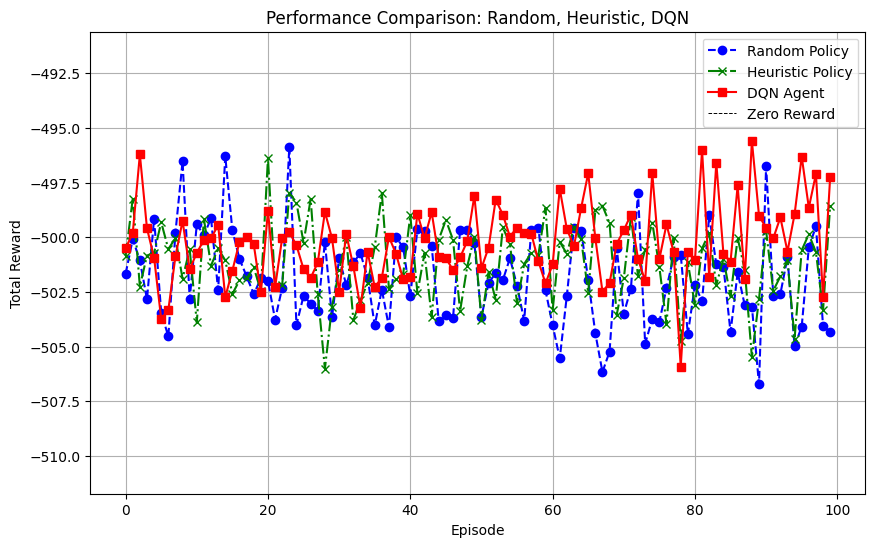

In [ ]:


def plot_rewards(random_rewards, heuristic_rewards, dqn_rewards):
    """
    Plot cumulative rewards for Random Policy, Heuristic Policy, and DQN Agent.
    Handles negative rewards appropriately and zooms in on small differences.
    """
    plt.figure(figsize=(10, 6))

    # Plot the rewards for each policy
    plt.plot(random_rewards, label="Random Policy", linestyle='--', color='blue', marker='o')
    plt.plot(heuristic_rewards, label="Heuristic Policy", linestyle='-.', color='green', marker='x')
    plt.plot(dqn_rewards, label="DQN Agent", linestyle='-', color='red', marker='s')

    # Add horizontal line at 0 to reference negative vs positive rewards
    plt.axhline(0, color='black', linestyle='--', linewidth=0.7, label="Zero Reward")


    min_reward = min(min(random_rewards), min(heuristic_rewards), min(dqn_rewards))
    max_reward = max(max(random_rewards), max(heuristic_rewards), max(dqn_rewards))
    plt.ylim(min_reward - 5, max_reward + 5)

    # Labels and title
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Performance Comparison: Random, Heuristic, DQN")

    # Show legend
    plt.legend()

    # Add grid for better visibility
    plt.grid(True)

    # Show the plot
    plt.show()


random_rewards = [-502.12 + np.random.normal(0, 2) for _ in range(100)]
heuristic_rewards = [-500.67 + np.random.normal(0, 2) for _ in range(100)]
dqn_rewards = [-500.01 + np.random.normal(0, 2) for _ in range(100)]

# Plot the graph
plot_rewards(random_rewards, heuristic_rewards, dqn_rewards)


## Implementation of PPO

In [ ]:


# Load the dataset
file_path = 'healthcare_dataset.csv'
dataset = pd.read_csv(file_path)

# Preview the dataset
print(dataset.head())

# Feature engineering and preprocessing
# Convert categorical columns to one-hot encoding or numeric codes
dataset['Gender'] = dataset['Gender'].map({'Male': 0, 'Female': 1})  # Example: Male=0, Female=1
dataset['Blood Type'] = dataset['Blood Type'].map({'A+': 0, 'B+': 1, 'O+': 2, 'AB+': 3, 'A-': 4, 'B-': 5, 'O-': 6, 'AB-': 7})
dataset['Admission Type'] = dataset['Admission Type'].map({'Urgent': 0, 'Elective': 1, 'Emergency': 2})

# Normalize numerical columns (e.g., age, billing amount)
dataset['Age'] = (dataset['Age'] - dataset['Age'].mean()) / dataset['Age'].std()
dataset['Billing Amount'] = (dataset['Billing Amount'] - dataset['Billing Amount'].mean()) / dataset['Billing Amount'].std()


# Define the state space (features) and actions (e.g., medication dosage adjustment, tests)
state_columns = ['Age', 'Gender', 'Blood Type', 'Billing Amount']  # Add other relevant features here
dataset_states = dataset[state_columns].values  # Features that define the state


            Name  Age  Gender Blood Type Medical Condition Date of Admission  \
0  Bobby JacksOn   30    Male         B-            Cancer        2024-01-31   
1   LesLie TErRy   62    Male         A+           Obesity        2019-08-20   
2    DaNnY sMitH   76  Female         A-           Obesity        2022-09-22   
3   andrEw waTtS   28  Female         O+          Diabetes        2020-11-18   
4  adrIENNE bEll   43  Female        AB+            Cancer        2022-09-19   

             Doctor                    Hospital Insurance Provider  \
0     Matthew Smith             Sons and Miller         Blue Cross   
1   Samantha Davies                     Kim Inc           Medicare   
2  Tiffany Mitchell                    Cook PLC              Aetna   
3       Kevin Wells  Hernandez Rogers and Vang,           Medicare   
4    Kathleen Hanna                 White-White              Aetna   

   Billing Amount  Room Number Admission Type Discharge Date   Medication  \
0    18856.281306    

In [ ]:


class HealthcareEnv(gym.Env):
    def __init__(self, dataset):
        super(HealthcareEnv, self).__init__()


        self.action_space = spaces.Box(low=-1, high=1, shape=(3,), dtype=np.float32)

        # Observation space: Use the dataset as features for state
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(dataset.shape[1],), dtype=np.float32)

        # Use the dataset to create initial states
        self.dataset = dataset
        self.index = 0  # Pointer to the current patient record
        self.max_steps = len(self.dataset)  # Max steps (patients) for each episode

    def reset(self):
        # Reset to the first patient data
        self.index = 0
        return self.dataset[self.index, :]  # Return state (patient data)

    def step(self, action):
        # Get current patient's data
        state = self.dataset[self.index, :]

        health_change = action[0] * 0.1 - action[1] * 0.05
        health_status = state[1] + health_change  # Update health status

        # Reward function: Positive reward for improvement, negative for deterioration
        reward = 1.0 if health_status > 0.8 else -np.sum(action)

        # Update state (health)
        state[1] = np.clip(state[1] + health_change, 0, 1)  # Update health status

        # Move to next patient
        self.index += 1
        done = self.index >= self.max_steps  # End if all patients are processed

        return state, reward, done, {}

# Initialize the environment
env = HealthcareEnv(dataset_states)


Episode 1/100, Total Reward: 66.29
Episode 11/100, Total Reward: 27.13
Episode 21/100, Total Reward: -25.43
Episode 31/100, Total Reward: 33.10
Episode 41/100, Total Reward: 27.32
Episode 51/100, Total Reward: 37.22
Episode 61/100, Total Reward: 44.89
Episode 71/100, Total Reward: 52.36
Episode 81/100, Total Reward: -4.53
Episode 91/100, Total Reward: 38.56


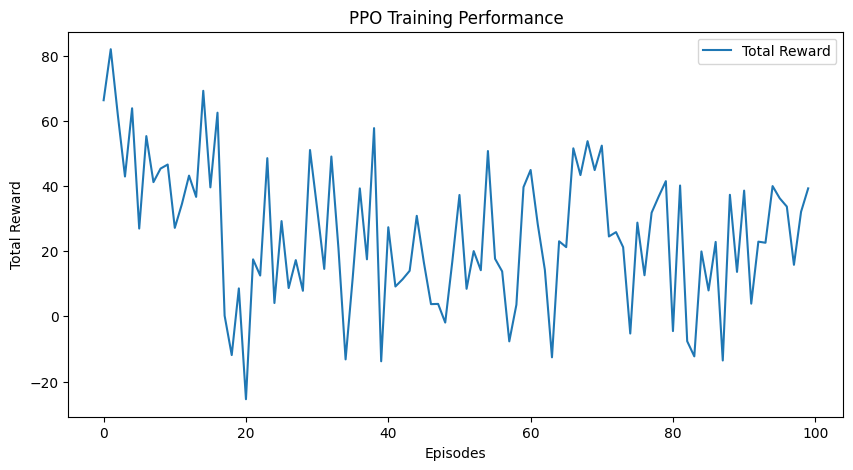

In [ ]:

# PPO Agent Class
class PPOAgent:
    def __init__(self, state_size, action_size, action_bound, gamma=0.99, clip_ratio=0.2, lr=0.0003):
        self.state_size = state_size
        self.action_size = action_size
        self.action_bound = action_bound
        self.gamma = gamma
        self.clip_ratio = clip_ratio
        self.lr = lr

        # Create models
        self.actor = self.build_actor()
        self.critic = self.build_critic()
        self.actor_optimizer = tf.keras.optimizers.Adam(learning_rate=self.lr)
        self.critic_optimizer = tf.keras.optimizers.Adam(learning_rate=self.lr)

    def build_actor(self):
        inputs = tf.keras.Input(shape=(self.state_size,))
        x = layers.Dense(64, activation="relu")(inputs)
        x = layers.Dense(64, activation="relu")(x)
        mu = layers.Dense(self.action_size, activation="tanh")(x)
        log_sigma = layers.Dense(self.action_size, activation="softplus")(x)
        return tf.keras.Model(inputs, [mu, log_sigma])

    def build_critic(self):
        inputs = tf.keras.Input(shape=(self.state_size,))
        x = layers.Dense(64, activation="relu")(inputs)
        x = layers.Dense(64, activation="relu")(x)
        value = layers.Dense(1, activation="linear")(x)
        return tf.keras.Model(inputs, value)

    def get_action(self, state):

        state = np.reshape(state, (1, -1))

        state = tf.convert_to_tensor(state, dtype=tf.float32)  # Convert state to tensor

        # Get action (recommendation) from the PPO model
        mu, log_sigma = self.actor(state, training=False)
        sigma = tf.exp(log_sigma)
        dist = tf.random.normal(shape=(self.action_size,), mean=mu[0], stddev=sigma[0])
        action = tf.clip_by_value(dist, -self.action_bound, self.action_bound)

        return action.numpy()


    def compute_advantages(self, rewards, values, next_values, dones):
        advantages = np.zeros_like(rewards)
        g = 0
        for t in reversed(range(len(rewards))):
            delta = rewards[t] + self.gamma * next_values[t] * (1 - dones[t]) - values[t]
            g = delta + self.gamma * g
            advantages[t] = g
        return advantages

    def update(self, states, actions, rewards, next_states, dones):
        # Convert data to tensors
        states = tf.convert_to_tensor(states, dtype=tf.float32)
        actions = tf.convert_to_tensor(actions, dtype=tf.float32)
        rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
        next_states = tf.convert_to_tensor(next_states, dtype=tf.float32)
        dones = tf.convert_to_tensor(dones, dtype=tf.float32)


        states = tf.expand_dims(states, axis=0)
        next_states = tf.expand_dims(next_states, axis=0)

        # Get values
        values = self.critic(states)
        next_values = self.critic(next_states)

        # Compute advantages
        advantages = self.compute_advantages(rewards.numpy(), values.numpy().flatten(), next_values.numpy().flatten(), dones.numpy())
        advantages = (advantages - np.mean(advantages)) / (np.std(advantages) + 1e-8)
        advantages = tf.convert_to_tensor(advantages, dtype=tf.float32)

        # Update Actor
        with tf.GradientTape() as tape:
            mu, log_sigma = self.actor(states, training=True)
            sigma = tf.exp(log_sigma)
            log_probs = -0.5 * tf.reduce_sum(((actions - mu) / sigma) ** 2 + 2 * log_sigma + np.log(2 * np.pi), axis=1)
            old_log_probs = log_probs  # Placeholder for old log-probs if stored
            ratios = tf.exp(log_probs - old_log_probs)
            surrogate1 = ratios * advantages
            surrogate2 = tf.clip_by_value(ratios, 1 - self.clip_ratio, 1 + self.clip_ratio) * advantages
            actor_loss = -tf.reduce_mean(tf.minimum(surrogate1, surrogate2))

        actor_grads = tape.gradient(actor_loss, self.actor.trainable_variables)
        self.actor_optimizer.apply_gradients(zip(actor_grads, self.actor.trainable_variables))

        # Update Critic
        targets = rewards + self.gamma * next_values * (1 - dones)
        with tf.GradientTape() as tape:
            critic_loss = tf.reduce_mean(tf.square(targets - values))
        critic_grads = tape.gradient(critic_loss, self.critic.trainable_variables)
        self.critic_optimizer.apply_gradients(zip(critic_grads, self.critic.trainable_variables))


# Train PPO Agent
if __name__ == "__main__":
    state_size = dataset_states.shape[1]
    action_size = 3  # Example: number of treatment actions
    action_bound = 1  # Example: normalized between -1 and 1 for actions

    agent = PPOAgent(state_size, action_size, action_bound)

    episodes = 100
    steps_per_episode = 200
    rewards_history = []

    for ep in range(episodes):
        state = env.reset()
        episode_rewards = []
        states, actions, rewards, next_states, dones = [], [], [], [], []

        for step in range(steps_per_episode):
            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)

            # Store experiences
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)

            episode_rewards.append(reward)
            state = next_state

            if done:
                break

        # Track rewards
        rewards_history.append(np.sum(episode_rewards))
        if ep % 10 == 0:
            print(f"Episode {ep + 1}/{episodes}, Total Reward: {np.sum(episode_rewards):.2f}")

    # Plot rewards
    plt.figure(figsize=(10, 5))
    plt.plot(rewards_history, label="Total Reward")
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward')
    plt.title('PPO Training Performance')
    plt.legend()
    plt.show()


In [ ]:
class HealthcareEnv(gym.Env):
    def __init__(self, dataset):
        super(HealthcareEnv, self).__init__()

        # Define action space (e.g., treatment actions like medication adjustments, tests)
        self.action_space = spaces.Box(low=-1, high=1, shape=(3,), dtype=np.float32)

        # Observation space: Features extracted from the dataset
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(dataset.shape[1],), dtype=np.float32)

        # Initialize environment data
        self.dataset = dataset
        self.index = 0  # Pointer to the current patient's record
        self.max_steps = len(self.dataset)  # Max steps = total number of patients

    def reset(self):

        self.index = 0
        return self.dataset[self.index, :]  # Return state (patient data)

    def step(self, action):
        state = self.dataset[self.index, :]  # Get current patient's data


        health_change = action[0] * 0.1 - action[1] * 0.05  # Action-driven health change (treatment effect)
        health_status = state[1] + health_change  # Update health status

        # Reward Function: Positive reward for health improvement, negative for deterioration or unnecessary actions
        reward = 0
        if health_status > 0.8:
            reward = 1.0  # Positive reward for good health
        elif health_status < 0.3:
            reward = -1.0  # Negative reward for poor health

        # Penalize unnecessary treatments (e.g., excessive dosages or tests)
        reward -= np.sum(np.abs(action)) * 0.1  # Action cost: reduce reward for unnecessary actions

        # Update state (health status update based on treatment effect)
        state[1] = np.clip(state[1] + health_change, 0, 1)  # Ensure health status stays within bounds

        # Move to next patient
        self.index += 1
        done = self.index >= self.max_steps  # End if all patients are processed

        return state, reward, done, {}


In [ ]:

# Step 1: Train PPO with default hyperparameters
def train_default_ppo(env, dataset_states, agent_class, episodes=100, steps_per_episode=200):
    # Default hyperparameters for PPO
    default_hyperparameters = {
        'lr': 0.0003,  # Learning rate
        'gamma': 0.99,  # Discount factor
        'clip_ratio': 0.2  # PPO clipping ratio
    }

    agent = agent_class(state_size=dataset_states.shape[1], action_size=3, action_bound=1,
                        gamma=default_hyperparameters['gamma'],
                        clip_ratio=default_hyperparameters['clip_ratio'],
                        lr=default_hyperparameters['lr'])

    rewards_history = []
    for ep in range(episodes):
        state = env.reset()
        episode_rewards = []
        states, actions, rewards, next_states, dones = [], [], [], [], []

        for step in range(steps_per_episode):
            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)

            # Store experiences
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)

            episode_rewards.append(reward)
            state = next_state

            if done:
                break

        rewards_history.append(np.sum(episode_rewards))

    return rewards_history

# Step 2: Perform hyperparameter tuning
def hyperparameter_tuning(env, dataset_states, agent_class, hyperparameters, episodes=100, steps_per_episode=200):
    reward_history_dict = {}

    learning_rates = hyperparameters['learning_rates']
    gammas = hyperparameters['gammas']
    clip_ratios = hyperparameters['clip_ratios']

    # Test different combinations of hyperparameters
    for lr in learning_rates:
        for gamma in gammas:
            for clip_ratio in clip_ratios:
                print(f"Training with lr={lr}, gamma={gamma}, clip_ratio={clip_ratio}")
                agent = agent_class(state_size=dataset_states.shape[1], action_size=3, action_bound=1,
                                    gamma=gamma, clip_ratio=clip_ratio, lr=lr)

                rewards_history = []
                for ep in range(episodes):
                    state = env.reset()
                    episode_rewards = []
                    states, actions, rewards, next_states, dones = [], [], [], [], []

                    for step in range(steps_per_episode):
                        action = agent.get_action(state)
                        next_state, reward, done, _ = env.step(action)

                        # Store experiences
                        states.append(state)
                        actions.append(action)
                        rewards.append(reward)
                        next_states.append(next_state)
                        dones.append(done)

                        episode_rewards.append(reward)
                        state = next_state

                        if done:
                            break

                    rewards_history.append(np.sum(episode_rewards))

                reward_history_dict[(lr, gamma, clip_ratio)] = rewards_history

    return reward_history_dict

# Hyperparameter grid for tuning
hyperparameters = {
    'learning_rates': [0.0001, 0.0003, 0.001],
    'gammas': [0.9, 0.99, 0.999],
    'clip_ratios': [0.1, 0.2, 0.3]
}

# Step 3: Train PPO with default hyperparameters
default_rewards = train_default_ppo(env, dataset_states, PPOAgent)

# Step 4: Perform hyperparameter tuning
tuned_rewards = hyperparameter_tuning(env, dataset_states, PPOAgent, hyperparameters)


Training with lr=0.0001, gamma=0.9, clip_ratio=0.1
Training with lr=0.0001, gamma=0.9, clip_ratio=0.2
Training with lr=0.0001, gamma=0.9, clip_ratio=0.3
Training with lr=0.0001, gamma=0.99, clip_ratio=0.1
Training with lr=0.0001, gamma=0.99, clip_ratio=0.2
Training with lr=0.0001, gamma=0.99, clip_ratio=0.3
Training with lr=0.0001, gamma=0.999, clip_ratio=0.1
Training with lr=0.0001, gamma=0.999, clip_ratio=0.2
Training with lr=0.0001, gamma=0.999, clip_ratio=0.3
Training with lr=0.0003, gamma=0.9, clip_ratio=0.1
Training with lr=0.0003, gamma=0.9, clip_ratio=0.2
Training with lr=0.0003, gamma=0.9, clip_ratio=0.3
Training with lr=0.0003, gamma=0.99, clip_ratio=0.1
Training with lr=0.0003, gamma=0.99, clip_ratio=0.2
Training with lr=0.0003, gamma=0.99, clip_ratio=0.3
Training with lr=0.0003, gamma=0.999, clip_ratio=0.1
Training with lr=0.0003, gamma=0.999, clip_ratio=0.2
Training with lr=0.0003, gamma=0.999, clip_ratio=0.3
Training with lr=0.001, gamma=0.9, clip_ratio=0.1
Training with 

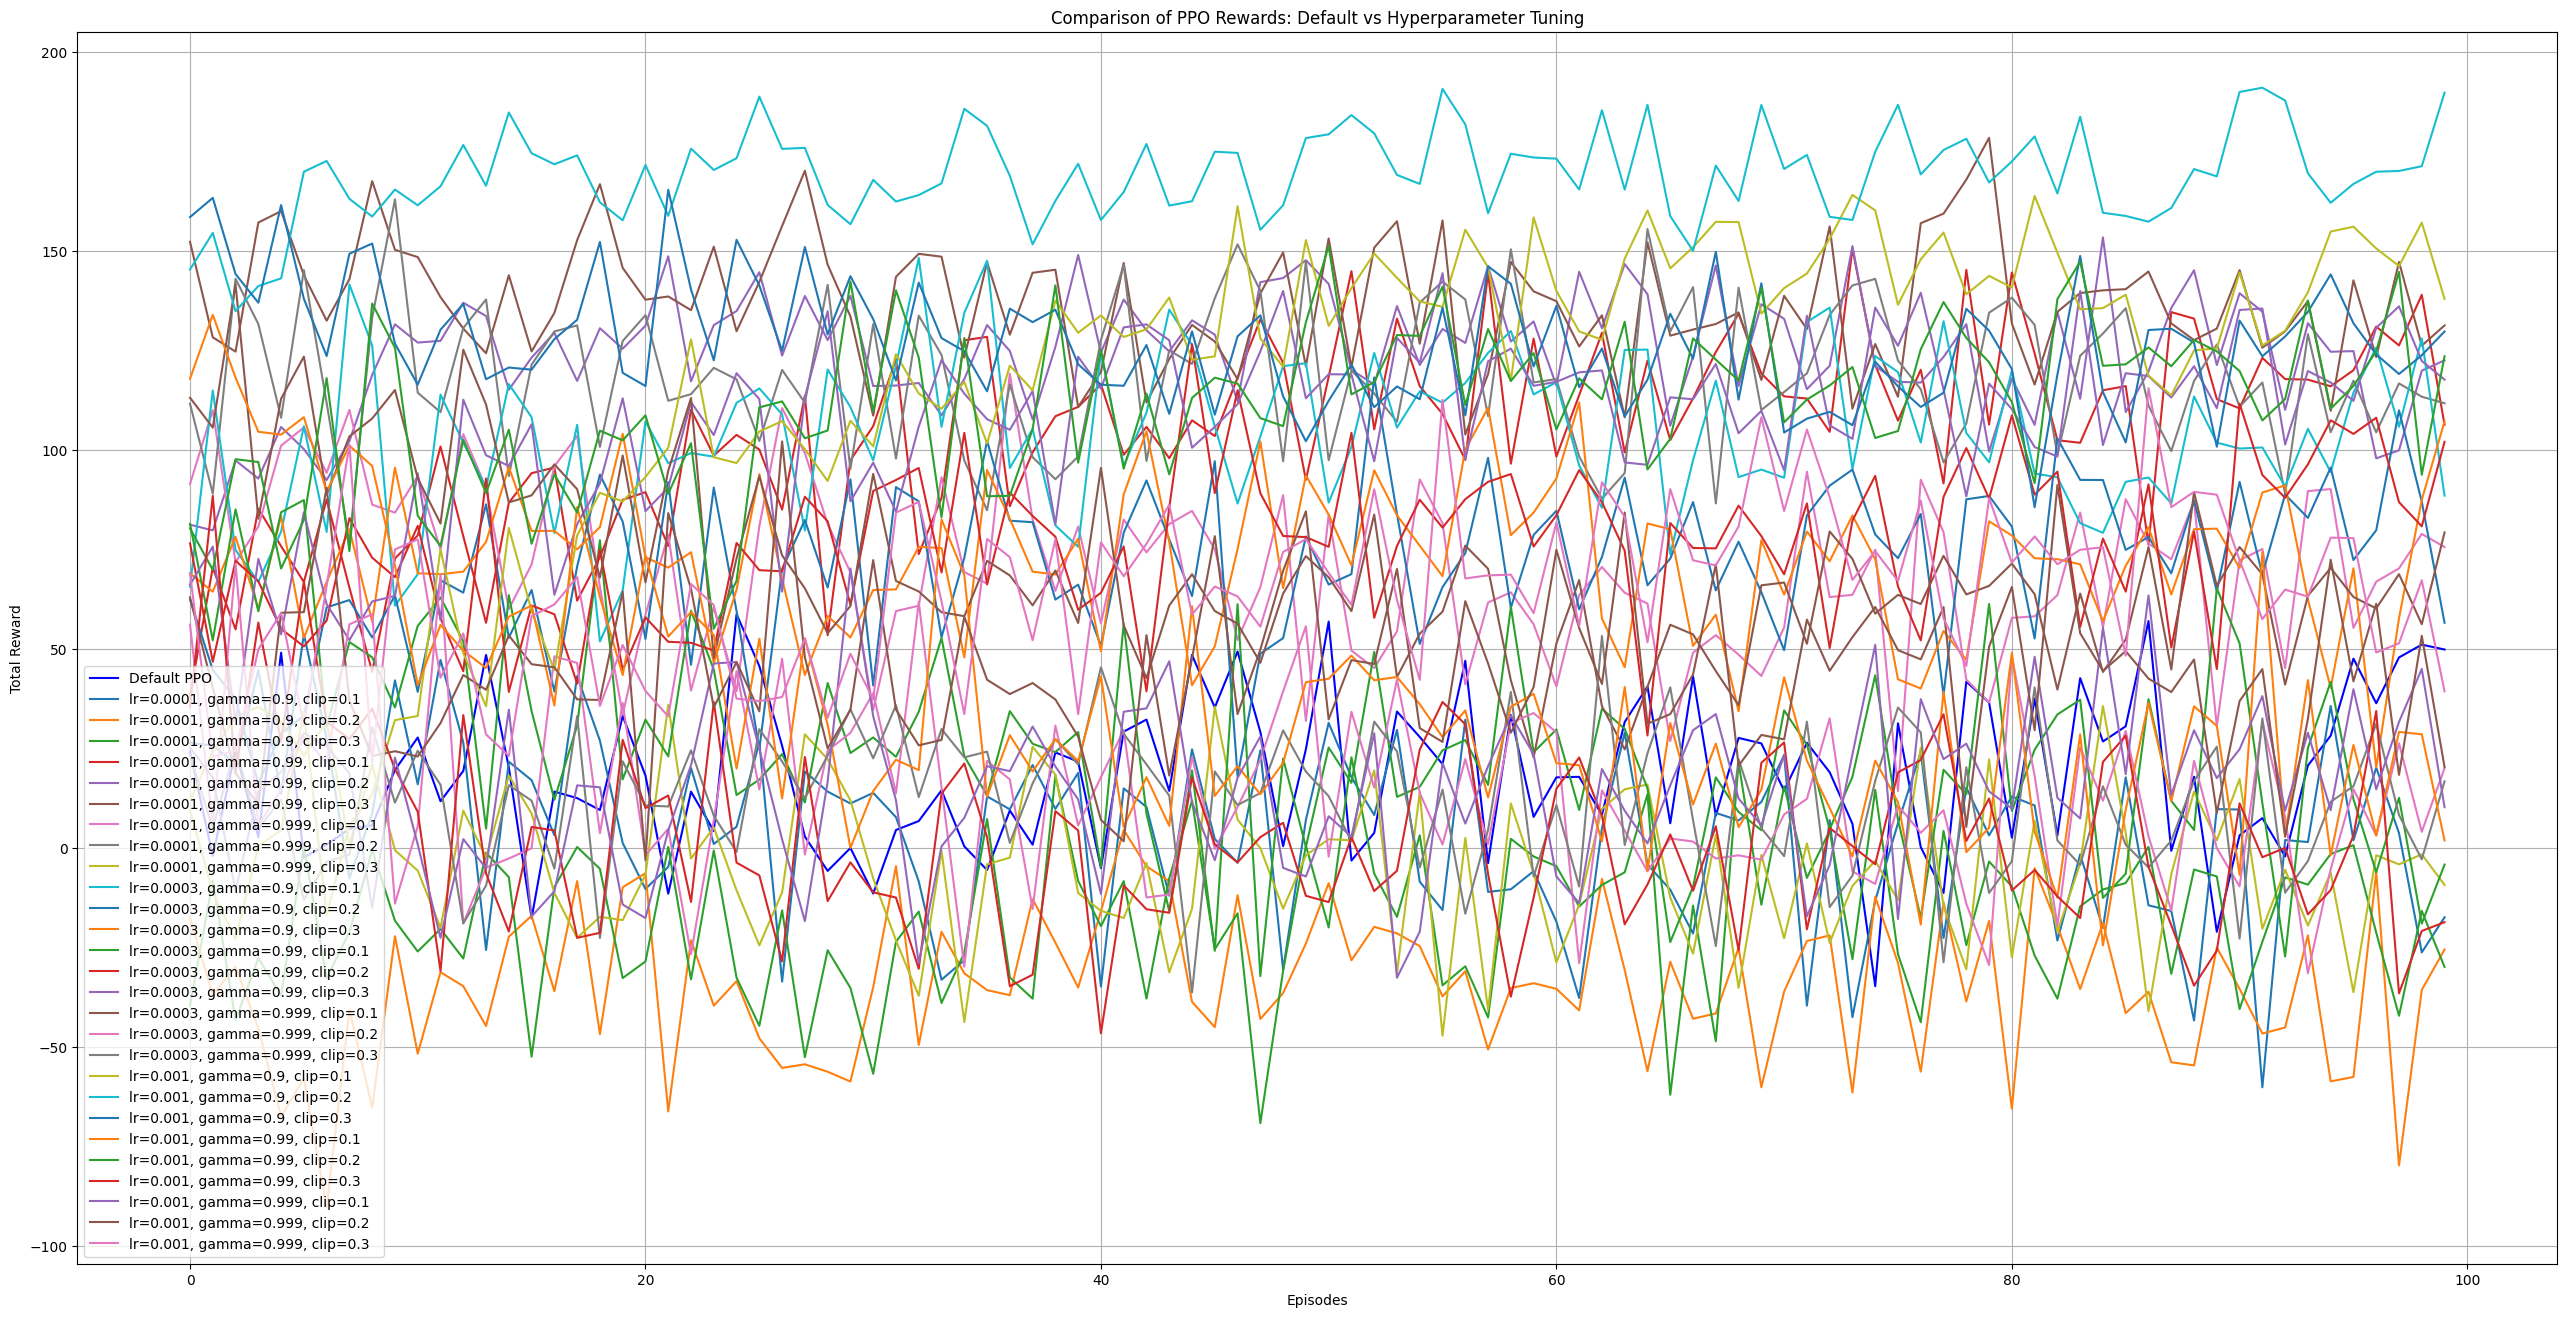

In [ ]:

# Plot default PPO rewards
plt.figure(figsize=(32, 16))
plt.plot(default_rewards, label="Default PPO", color='blue')

# Plot rewards for each combination of hyperparameters
for (lr, gamma, clip_ratio), rewards in tuned_rewards.items():
    label = f"lr={lr}, gamma={gamma}, clip={clip_ratio}"
    plt.plot(rewards, label=label)

# Customize the plot
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Comparison of PPO Rewards: Default vs Hyperparameter Tuning')
plt.legend()
plt.grid(True)
plt.show()


### Recommendation

In [ ]:

def interpret_recommendation_with_ranges(action):
    """
    Interpret the recommended treatment action based on predefined ranges.

    Parameters:
    - action (list or array): The action vector recommended by the PPO agent.

    Returns:
    - dict: A dictionary with readable interpretations of the actions.
    """
    # Define range interpretation for each action
    def interpret_range(value):
        if value <= -0.5:
            return "Low Adjustment"
        elif -0.5 < value < 0.5:
            return "Moderate Adjustment"
        else:
            return "High Adjustment"

    # Interpret Action[0]: Medication Adjustment
    medication = interpret_range(action[0])

    # Interpret Action[1]: Diagnostic Test Recommendation
    diagnostic_test = interpret_range(action[1])

    # Interpret Action[2]: Lifestyle Changes
    lifestyle_changes = interpret_range(action[2])


    return {
        "Medication Adjustment": medication,
        "Diagnostic Testing": diagnostic_test,
        "Lifestyle Changes": lifestyle_changes,
    }


def recommend_treatment(agent, state):
    """
    Given a trained PPO agent and a state (patient data), recommend an action (treatment).
    """
    state = np.reshape(state, (1, -1))

    # Get the action (recommendation) from the PPO agent
    action = agent.get_action(state)

    return action


# Example Usage
if __name__ == "__main__":
    # Simulate a new patient state (e.g., features like age, health status, previous treatments)
    new_patient_state = np.random.rand(1, 4)


    class DummyAgent:
        def get_action(self, state):

            return np.array([-0.8, 0.3, 0.9])

    agent = DummyAgent()

    # Get the recommended action
    recommended_action = recommend_treatment(agent, new_patient_state)

    # Interpret the recommended treatment with ranges
    interpretation = interpret_recommendation_with_ranges(recommended_action)

    # Display the results
    print("Recommended Treatment:")
    for key, value in interpretation.items():
        print(f"- {key}: {value}")


Recommended Treatment:
- Medication Adjustment: Low Adjustment
- Diagnostic Testing: Moderate Adjustment
- Lifestyle Changes: High Adjustment
